In [1]:
import os
import random
import shutil
import glob as gb
from tqdm import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img,img_to_array 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D,Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

from keras import Model
from keras.layers import Input

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

2025-04-22 20:21:16.659257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 20:21:16.659371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 20:21:16.781821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DataPath = '/kaggle/input/cctv-gender-classifier-dataset/CCTV Gender Classifier Dataset'

labels2int={"MALE":0,"FEMALE":1}
int2labels={0:"MALE",1:"FEMALE"}

Data = []
Classes = []

# Iterate through each folder in DataPath
for folder in os.listdir(DataPath):
    print(folder)
    
    # Construct the full path to the folder
    folder_path = os.path.join(DataPath, folder)
    
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    print(f"Data found {len(files)} in {folder}")
    
    # Iterate through each file in the folder
    for file in files:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Load the image, resize it, and convert it to an array
        img = load_img(file_path, target_size=(128, 128))
        img_array = img_to_array(img)
        
        # Preprocess the image array
        img_array = preprocess_input(img_array)
        
        # Append the preprocessed image array to the Data list
        Data.append(img_array)
        
        # Append the label to the Classes list based on the folder name
        Classes.append(labels2int[folder])

FEMALE
Data found 9676 in FEMALE
MALE
Data found 9447 in MALE


In [3]:
print("Length of Classes before binarization:", len(Classes))

Length of Classes before binarization: 19123


In [4]:
lb = LabelBinarizer()
Classes = lb.fit_transform(Classes)
Classes = to_categorical(Classes)

In [5]:
print("Shape of Classes after binarization and conversion:", Classes.shape)

Shape of Classes after binarization and conversion: (19123, 2)


In [6]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
trainx,testx,trainy,testy = train_test_split(Data,Classes,test_size=0.20,stratify=Classes,
                                             random_state=77,shuffle=True)
print("Shape of training data (trainx):", trainx.shape)
print("Shape of testing data (testx):", testx.shape)
print("Shape of training labels (trainy):", trainy.shape)
print("Shape of testing labels (testy):", testy.shape)

Shape of training data (trainx): (15298, 128, 128, 3)
Shape of testing data (testx): (3825, 128, 128, 3)
Shape of training labels (trainy): (15298, 2)
Shape of testing labels (testy): (3825, 2)


In [7]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
# Split data into training and testing sets (80% train, 20% test)
Data_train, Data_test, Classes_train, Classes_test = train_test_split(Data, Classes, test_size=0.2, random_state=77)

# Split training data into training and validation sets (80% train, 20% validation)
Data_train, Data_val, Classes_train, Classes_val = train_test_split(Data_train, Classes_train, test_size=0.2, random_state=77)

print("Shape of training data (Data_train):", Data_train.shape)
print("Shape of Validation data (Data_val):", Data_val.shape)
print("Shape of testing data (Data_test):", Data_test.shape)
print('=============================================================')
print("Shape of training labels (Classes_train):", Classes_train.shape)
print("Shape of Validation labels (Classes_test):", Classes_val.shape)
print("Shape of testing labels (Classes_test):", Classes_test.shape)

Shape of training data (Data_train): (12238, 128, 128, 3)
Shape of Validation data (Data_val): (3060, 128, 128, 3)
Shape of testing data (Data_test): (3825, 128, 128, 3)
Shape of training labels (Classes_train): (12238, 2)
Shape of Validation labels (Classes_test): (3060, 2)
Shape of testing labels (Classes_test): (3825, 2)


In [11]:
def resnet50_modelarch():
    lr = 1e-5
    epochs = 10
    
    basemodel= ResNet50(include_top=False, input_shape=(128,128,3))
    headmodel= basemodel.output
    headmodel= AveragePooling2D(pool_size=(3,3))(headmodel)
    
    #headmodel = Dense(1024, activation="relu")(headmodel)
    #headmodel = Dropout(0.3)(headmodel)
    headmodel = Flatten(name="flatten")(headmodel)
    headmodel = Dense(512, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(256, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(128, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(64, activation="relu")(headmodel)
    #headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(2, activation='softmax')(headmodel)
    
    model=Model(inputs=basemodel.input, outputs=headmodel)
    
    for layer in basemodel.layers:
        layer.trainable=False
        
    opt=Adam(learning_rate=lr, decay=lr / epochs)
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
    callback = EarlyStopping(monitor='val_loss',patience=6)
    
    return model,callback,epochs
    
model,callback,Epochs = resnet50_modelarch()

history = model.fit(Data_train,Classes_train,
                    batch_size=32,
                    validation_data=(Data_val,Classes_val),
                    epochs=30,callbacks=[callback])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.5305 - loss: 0.8077 - val_accuracy: 0.6346 - val_loss: 0.6584
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5906 - loss: 0.7076 - val_accuracy: 0.6621 - val_loss: 0.6339
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6158 - loss: 0.6772 - val_accuracy: 0.6716 - val_loss: 0.6158
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6408 - loss: 0.6503 - val_accuracy: 0.6866 - val_loss: 0.6013
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6573 - loss: 0.6349 - val_accuracy: 0.6944 - val_loss: 0.5859
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6652 - loss: 0.6202 - val_accuracy: 0.7010 - val_loss: 0.5742
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6807 - loss: 0.6040 - val_accuracy: 0.7042 - val_loss: 0.5622
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6839 - loss: 0.5988 - 

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def resnet50_modelarch():
    lr = 1e-5
    epochs = 30

    basemodel = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    headmodel = basemodel.output
    headmodel = AveragePooling2D(pool_size=(3, 3))(headmodel)
    headmodel = Flatten(name="flatten")(headmodel)
    headmodel = Dense(512, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(256, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(128, activation="relu")(headmodel)
    headmodel = Dropout(0.3)(headmodel)
    headmodel = Dense(64, activation="relu")(headmodel)
    headmodel = Dense(2, activation='softmax')(headmodel)

    model = Model(inputs=basemodel.input, outputs=headmodel)

    # Freeze most of the base model, fine-tune last 20 layers
    for layer in basemodel.layers:
        layer.trainable = False
    for layer in basemodel.layers[-20:]:
        layer.trainable = True

    opt = Adam(learning_rate=lr)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', mode='max', save_best_only=True)

    return model, [early_stop, checkpoint], epochs

# ⬆️ Define Model Architecture

# ⬇️ Data Augmentation Setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Replace this with your actual data
# Assuming Data_train, Data_val, Classes_train, Classes_val are NumPy arrays
train_gen = train_datagen.flow(Data_train, Classes_train, batch_size=16)
val_gen = val_datagen.flow(Data_val, Classes_val, batch_size=16)

# 🚀 Train Model
model, callbacks, epochs = resnet50_modelarch()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/765 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5417 - loss: 0.7031   

I0000 00:00:1745353421.003248      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1745353421.051038      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5617 - loss: 0.6846

W0000 00:00:1745353486.992671      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


765/765 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - accuracy: 0.5618 - loss: 0.6845 - val_accuracy: 0.6507 - val_loss: 0.6280
Epoch 2/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.6246 - loss: 0.6514 - val_accuracy: 0.6562 - val_loss: 0.6135
Epoch 3/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.6280 - loss: 0.6428 - val_accuracy: 0.6637 - val_loss: 0.6041
Epoch 4/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.6472 - loss: 0.6308 - val_accuracy: 0.6611 - val_loss: 0.6008
Epoch 5/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.6485 - loss: 0.6297 - val_accuracy: 0.5990 - val_loss: 0.6482
Epoch 6/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.6477 - loss: 0.6210 - val_accuracy: 0.6422 - val_loss: 0.6070
Epoch 7/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.6602 - loss: 0.6189 - val_accuracy: 0.6954 - val_loss: 0.5756
Epoch 8/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.6564 - loss: 0.6150 - val_accurac

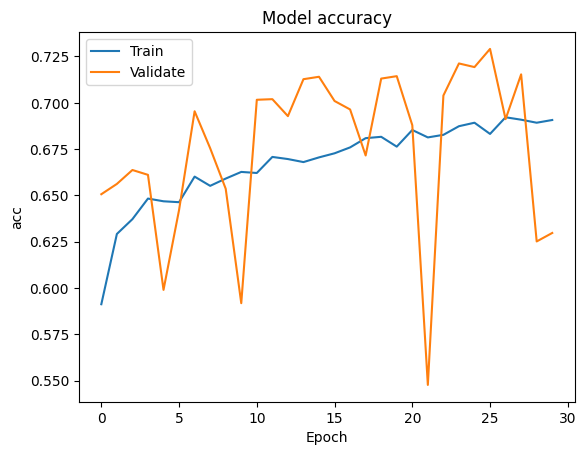

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [12]:
model.save("resnet77.keras")

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

In [ ]:
!pip install -q ultralytics

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import tensorflow as tf

# Load YOLOv8n for person detection
yolo_model = YOLO("yolov8n.pt")

# Load your trained Keras gender classification model
gender_model = tf.keras.models.load_model("/kaggle/working/yolov5/best_model.keras")

# Gender labels (edit if your classes are different)
gender_classes = ['Female', 'Male']

# Load the video file
video_path = "//kaggle/input/datset-cctv/face-demographics-walking.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("/kaggle/working/output_resnet82.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO detection
    results = yolo_model(frame)

    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            label = yolo_model.names[cls_id]

            if label != 'person':
                continue

            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            person_crop = frame[y1:y2, x1:x2]

            try:
                # Preprocess crop for gender classification
                resized = cv2.resize(person_crop, (128, 128))  # update if model expects different size
                normalized = resized / 255.0
                input_array = np.expand_dims(normalized, axis=0)

                # Predict gender
                preds = gender_model.predict(input_array, verbose=0)
                pred_class = np.argmax(preds)
                confidence = preds[0][pred_class]
                gender_label = f"{gender_classes[pred_class]} ({confidence*100:.1f}%)"

                # Draw results
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, gender_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.6, (255, 255, 255), 2)
            except Exception as e:
                print(f"Error processing crop: {e}")


    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Output video saved to: /kaggle/working/output_gender_yolo.mp4")